In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import warnings
import mlflow.sklearn

warnings.filterwarnings('ignore')

In [15]:
# Random State
RNG = 42

In [16]:
import os
mlflow_tracking_uri = os.path.join(os.path.dirname(os.getcwd()), 'mlruns')
print(f"MLflow tracking URI: {mlflow_tracking_uri}")

# Change to \\ if on Windows
if os.name == 'nt':
    mlflow.set_tracking_uri(f"file:\\{mlflow_tracking_uri}")
else:
    mlflow.set_tracking_uri(f"file://{mlflow_tracking_uri}")

mlflow.end_run()
mlflow.set_experiment("classification_models")

MLflow tracking URI: C:\Users\caleb\PycharmProjects\MLProject\CS4120-MLProject\project\mlruns


<Experiment: artifact_location='file:\\C:\\Users\\caleb\\PycharmProjects\\MLProject\\CS4120-MLProject\\project\\mlruns/637613118783091569', creation_time=1761758332462, experiment_id='637613118783091569', last_update_time=1761758332462, lifecycle_stage='active', name='classification_models', tags={}>

In [17]:
# Step 1: Load the data
df = pd.read_csv("../data/train.csv")

# Step 1.5: Feature Engineering - Remove low-value features and combine related ones

# Combine bathroom features
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df = df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Combine porch features into one
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df = df.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Drop low-variance features
df = df.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'], axis=1)

# Drop Year/Month sold (temporal features may cause overfitting)
df = df.drop(['MoSold', 'YrSold'], axis=1)

# Combine quality features
df['OverallScore'] = df['OverallQual'] * df['OverallCond']
# Redundant features
df = df.drop(['GarageType', 'GarageFinish', 'Fence', 'Alley'], axis=1)
df = df.drop(['LowQualFinSF', 'PoolArea', 'MiscVal'], axis=1)
df = df.drop(['GarageQual', 'GarageCond'], axis=1)
df = df.drop(['PoolQC', 'MiscFeature'], axis=1)


In [18]:
from utils import classify_price, get_median_price

# Step 2: Process Data
median_price = get_median_price(df)
df['PriceCategory'] = df['SalePrice'].apply(lambda x: classify_price(x, median_price))

# Remove Id and SalePrice columns
df = df.drop(['Id', 'SalePrice'], axis=1)

# Separate features and target
X = df.drop('PriceCategory', axis=1)
y = df['PriceCategory']

In [19]:
# Handle numeric and categorical features differently
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [20]:
# Pre-processing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('variance_filter', VarianceThreshold(threshold=0.1))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [21]:
# Step 3: Split Data into Train (80%), Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG, stratify=y
)

Cross-validation scores: [0.88013699 0.8869863  0.88013699 0.91780822]
Mean CV accuracy: 0.8913

Training accuracy: 0.8955
Training F1 (binary): 0.8946
Test accuracy: 0.9007
Test F1 (binary): 0.9010

Confusion Matrix (Test Set):
[[131  15]
 [ 14 132]]

Classes: 0 - Below Median, 1 - Above Median


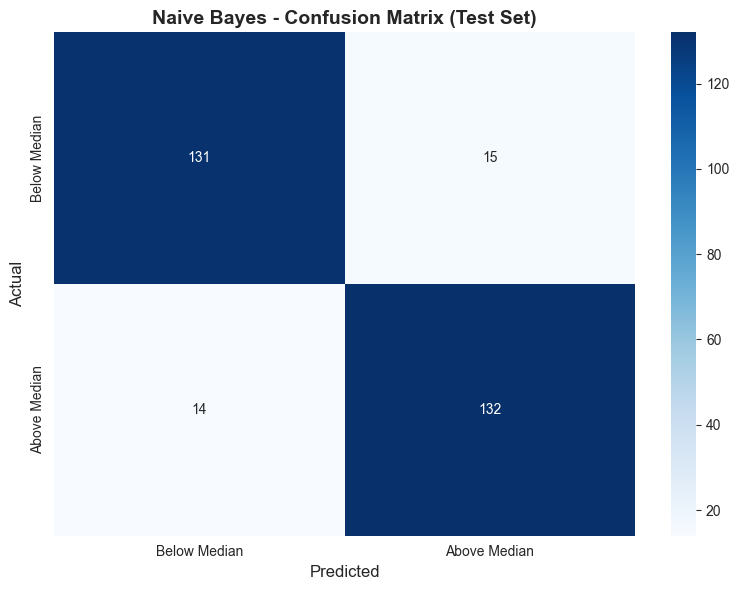

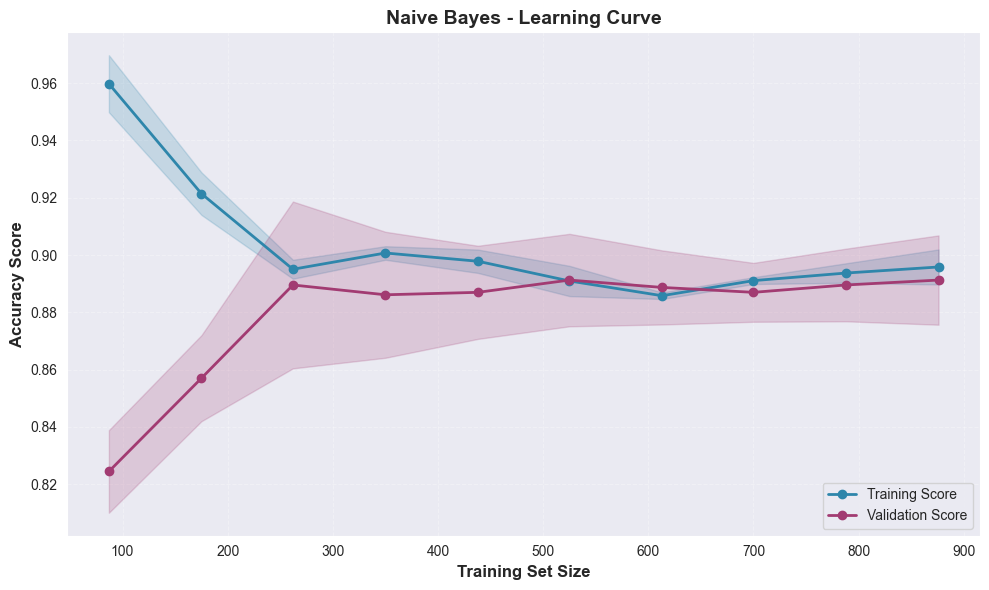

In [22]:
# Step 4: Train Naive Bayes Model and apply 4-fold cross-validation
with mlflow.start_run(run_name="Naive_Bayes"):
    mlflow.log_param("model_type", "GaussianNB")
    mlflow.log_param("cv_folds", 4)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", RNG)

    nb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
    nb_pipeline.fit(X_train, y_train)
    cv_scores_nb = cross_val_score(nb_pipeline, X_train, y_train, cv=4, scoring='accuracy')

    mlflow.log_metric("cv_mean_accuracy", cv_scores_nb.mean())
    mlflow.log_metric("cv_std_accuracy", cv_scores_nb.std())

    print(f"Cross-validation scores: {cv_scores_nb}")
    print(f"Mean CV accuracy: {cv_scores_nb.mean():.4f}")

    # Step 5: Evaluate Model Accuracy
    y_train_pred_nb = nb_pipeline.predict(X_train)
    train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
    train_f1_nb = f1_score(y_train, y_train_pred_nb, average='binary')

    mlflow.log_metric("train_accuracy", train_accuracy_nb)
    mlflow.log_metric("train_f1", train_f1_nb)

    print(f"\nTraining accuracy: {train_accuracy_nb:.4f}")
    print(f"Training F1 (binary): {train_f1_nb:.4f}")

    y_test_pred_nb = nb_pipeline.predict(X_test)
    test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
    test_f1_nb = f1_score(y_test, y_test_pred_nb, average='binary')

    mlflow.log_metric("test_accuracy", test_accuracy_nb)
    mlflow.log_metric("test_f1", test_f1_nb)

    print(f"Test accuracy: {test_accuracy_nb:.4f}")
    print(f"Test F1 (binary): {test_f1_nb:.4f}")

    print("\nConfusion Matrix (Test Set):")
    cm_nb = confusion_matrix(y_test, y_test_pred_nb)
    print(cm_nb)
    print("\nClasses: 0 - Below Median, 1 - Above Median")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Below Median', 'Above Median'],
                yticklabels=['Below Median', 'Above Median'])
    plt.title('Naive Bayes - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'nb_confusion_matrix.png')
    plt.show()

    # Learning Curve for Naive Bayes
    train_sizes, train_scores, val_scores = learning_curve(
        nb_pipeline, X_train, y_train, cv=4,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1, random_state=RNG
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', linewidth=2, markersize=6, label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2E86AB')
    plt.plot(train_sizes, val_mean, 'o-', color='#A23B72', linewidth=2, markersize=6, label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#A23B72')

    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy Score', fontsize=12, fontweight='bold')
    plt.title('Naive Bayes - Learning Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'nb_learning_curve.png')
    plt.show()

Fitting 4 folds for each of 16 candidates, totalling 64 fits

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best CV score from grid search: 0.9187
Cross-validation scores (best model): [0.91438356 0.9109589  0.92123288 0.92808219]
Mean CV accuracy (best model): 0.9187 (+/- 0.0066)

Training accuracy: 0.9503
Training F1 (binary): 0.9503
Test accuracy: 0.9452
Test F1 (binary): 0.9452

Confusion Matrix (Test Set):
[[138   8]
 [  8 138]]

Classes: 0 - Below Median, 1 - Above Median


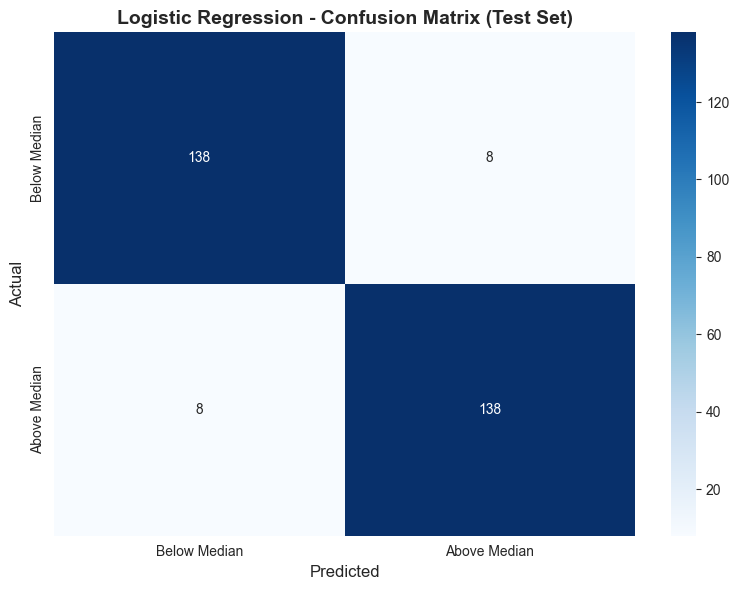

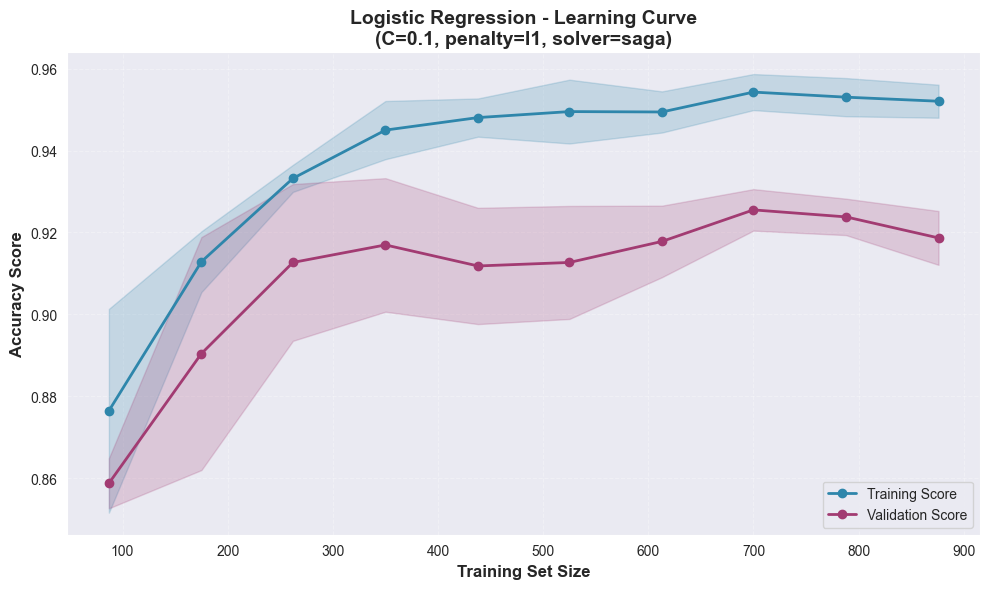

In [23]:
# Step 6: Train Logistic Regression Model and apply 4-fold cross-validation
with mlflow.start_run(run_name="Logistic_Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("cv_folds", 4)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", RNG)
    mlflow.log_param("scaler", "StandardScaler")

    lr_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=RNG))
    ])

    # Best params after running GridSearchCV: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
    lr_param_grid = {
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1.0, 10.0],
        'classifier__solver': ['saga', 'liblinear']
    }

    # Perform Grid Search with 4-fold cross-validation
    lr_grid_search = GridSearchCV(
        lr_pipeline,
        lr_param_grid,
        cv=4,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    lr_grid_search.fit(X_train, y_train)

    best_lr_params = lr_grid_search.best_params_
    lr_pipeline = lr_grid_search.best_estimator_

    print(f"\nBest parameters: {best_lr_params}")
    mlflow.log_params({f"best_{k}": v for k, v in best_lr_params.items()})

    # Step 7: Evaluate Model Accuracy using GridSearchCV results
    best_cv_score_lr = lr_grid_search.best_score_

    cv_scores_lr = cross_val_score(lr_pipeline, X_train, y_train, cv=4, scoring='accuracy')

    mlflow.log_metric("cv_mean_accuracy", cv_scores_lr.mean())
    mlflow.log_metric("cv_std_accuracy", cv_scores_lr.std())
    mlflow.log_metric("best_cv_score", best_cv_score_lr)

    print(f"Best CV score from grid search: {best_cv_score_lr:.4f}")
    print(f"Cross-validation scores (best model): {cv_scores_lr}")
    print(f"Mean CV accuracy (best model): {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

    y_train_pred_lr = lr_pipeline.predict(X_train)
    train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
    train_f1_lr = f1_score(y_train, y_train_pred_lr, average='binary')

    mlflow.log_metric("train_accuracy", train_accuracy_lr)
    mlflow.log_metric("train_f1", train_f1_lr)

    print(f"\nTraining accuracy: {train_accuracy_lr:.4f}")
    print(f"Training F1 (binary): {train_f1_lr:.4f}")

    y_test_pred_lr = lr_pipeline.predict(X_test)
    test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
    test_f1_lr = f1_score(y_test, y_test_pred_lr, average='binary')

    mlflow.log_metric("test_accuracy", test_accuracy_lr)
    mlflow.log_metric("test_f1", test_f1_lr)

    print(f"Test accuracy: {test_accuracy_lr:.4f}")
    print(f"Test F1 (binary): {test_f1_lr:.4f}")

    print("\nConfusion Matrix (Test Set):")
    cm_lr = confusion_matrix(y_test, y_test_pred_lr)
    print(cm_lr)
    print("\nClasses: 0 - Below Median, 1 - Above Median")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Below Median', 'Above Median'],
                yticklabels=['Below Median', 'Above Median'])
    plt.title('Logistic Regression - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'lr_confusion_matrix.png')
    plt.show()

    # Learning Curve for Logistic Regression
    train_sizes, train_scores, val_scores = learning_curve(
        lr_pipeline, X_train, y_train, cv=4,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', n_jobs=-1, random_state=RNG
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Create title with best parameters
    params_str = f"C={best_lr_params['classifier__C']}, penalty={best_lr_params['classifier__penalty']}, solver={best_lr_params['classifier__solver']}"
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#2E86AB', linewidth=2, markersize=6, label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#2E86AB')
    plt.plot(train_sizes, val_mean, 'o-', color='#A23B72', linewidth=2, markersize=6, label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#A23B72')

    plt.xlabel('Training Set Size', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy Score', fontsize=12, fontweight='bold')
    plt.title(f'Logistic Regression - Learning Curve\n({params_str})', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()

    mlflow.log_figure(plt.gcf(), 'lr_learning_curve.png')
    plt.show()

In [24]:
# Summary
print(f"\nNaive Bayes:")
print(f"  - Mean CV Accuracy: {cv_scores_nb.mean():.4f} (+/- {cv_scores_nb.std():.4f})")
print(f"  - Training Accuracy: {train_accuracy_nb:.4f}")
print(f"  - Test Accuracy: {test_accuracy_nb:.4f}")

print(f"\nLogistic Regression:")
print(f"  - Best CV Score (Grid Search): {best_cv_score_lr:.4f}")
print(f"  - Mean CV Accuracy (Best Model): {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")
print(f"  - Best Parameters: {best_lr_params}")
print(f"  - Training Accuracy: {train_accuracy_lr:.4f}")
print(f"  - Test Accuracy: {test_accuracy_lr:.4f}")


Naive Bayes:
  - Mean CV Accuracy: 0.8913 (+/- 0.0156)
  - Training Accuracy: 0.8955
  - Test Accuracy: 0.9007

Logistic Regression:
  - Best CV Score (Grid Search): 0.9187
  - Mean CV Accuracy (Best Model): 0.9187 (+/- 0.0066)
  - Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
  - Training Accuracy: 0.9503
  - Test Accuracy: 0.9452


In [25]:
# Train and Test Metrics and F1 Table
metrics_data = {
    'Model': ['Naive Bayes', 'Logistic Regression'],
    'CV Accuracy': [cv_scores_nb.mean(), cv_scores_lr.mean()],
    'Train Accuracy': [train_accuracy_nb, train_accuracy_lr],
    'Train F1': [train_f1_nb, train_f1_lr],
    'Test Accuracy': [test_accuracy_nb, test_accuracy_lr],
    'Test F1': [test_f1_nb, test_f1_lr],
}

metrics_df = pd.DataFrame(metrics_data)

for col in ['CV Accuracy', 'Train Accuracy', 'Train F1', 'Test Accuracy', 'Test F1']:
    metrics_df[col] = metrics_df[col].apply(lambda x: f"{x:.4f}")

print("\n" + "-"*80)
print("CLASSIFICATION METRICS FOR ALL MODELS: Accuracy, and F1 on Validation (CV) and Test")
print("-"*80)
print(metrics_df.to_string(index=False))
print("-"*80)


--------------------------------------------------------------------------------
CLASSIFICATION METRICS FOR ALL MODELS: Accuracy, and F1 on Validation (CV) and Test
--------------------------------------------------------------------------------
              Model CV Accuracy Train Accuracy Train F1 Test Accuracy Test F1
        Naive Bayes      0.8913         0.8955   0.8946        0.9007  0.9010
Logistic Regression      0.9187         0.9503   0.9503        0.9452  0.9452
--------------------------------------------------------------------------------


In [26]:
mlflow.end_run()